(dag_correlated_errors)=
# Modeling data with correlated errors across a directed graph

:::{post} 28 Mar, 2025
:tags: graph, network 
:category: advanced, how-to
:author: Christopher Krapu
:::

Data for objects which can be linked together with a graph are common in fields like epidemiology and sociology. A simple way to model this kind of data is with a linear mixed model with a random effect with some network structure, or an error term which is correlated. The former is appropriate when you have multiple observations for each node in your graph while the latter is applicable when there is usually just one data point for each node. 

PyMC has functionality for these kinds of models assuming an **undirected** graph. This makes sense if it's not clear which way the causality goes. For example, if the number of infected people in city $A$ is correlated with the same quantity in city $B$ because there is a road from $A$ to $B$, then the correlation could be due to people traveling from $A$ to $B$, from $B$ to $A$, or both processes simultaneously. This is a great opportunity to use a Gaussian Markov random field, synonomous with [conditional autoregression](https://www.pymc.io/projects/examples/en/latest/spatial/conditional_autoregressive_priors.html).

Many real-world networks are actually **directed** graphs, however. An example of this type is a river network. Water flows in one direction, and events like floods or pollutant spills which occur downstream will generally not have an effect on the upstream segments of the network. 

In the case where we have a directed graph, we can use some tricks from linear algebra to account for this network-based correlation to help produce more accurate estimates of regression coefficients and better predictive performance on new data.In this notebook, we'll use some basic matrix facts and identities to implement a highly scalable and effective linear mixed model for network data assuming an underlying directed acyclic graph (DAG). To learn more about these terms and concepts, I highly recommend selected chapters from [*Statistical Rethinking*](https://github.com/rmcelreath/stat_rethinking_2024/tree/main?tab=readme-ov-file) and [*Probabilistic Graphical Models*](https://www.google.com/books/edition/Probabilistic_Graphical_Models/7dzpHCHzNQ4C?hl=en&gbpv=1&pg=PA1&printsec=frontcover).

:::{include} ../extra_installs.md
:::

In [1]:
import arviz as az
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import pytensor.sparse as sparse
import scipy as sp
import seaborn as sns
import xarray as xr

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from numpy.random import default_rng
from xarray_einstats import linalg
from xarray_einstats.stats import XrContinuousRV
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.21.1


In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

np.set_printoptions(precision=3, suppress=True)
RANDOM_SEED = 8271991
rng = default_rng(RANDOM_SEED)

## Model structure

To illustrate why we should account for any underlying network structure in our dataset, let's start with an example using synthetic data. We'll assume the following probabilistic model for $N$ data points for the rest of the notebook:

$$ \mathbf{y} \sim \textbf{N}(X \beta, \Sigma) \text{ or equivalently } \mathbf{y}  = X \beta + \mathbf{\epsilon}\text{, } \epsilon \sim \textbf{N}(0, \Sigma)$$
$$ \beta_j \sim \text{HalfCauchy}(1) \text{ for all } j \in \{1,..,P\}$$

We'll use $P = 2$ in this example, though the role of the linear predictor $X \beta$ is not important. $\mathbf{y}$ is a vector of observations with correlated errors; the structure of this correlation is encoded in the elements of $\Sigma$, an $N\times N$ covariance matrix.

Another assumption we will make is that the index $i \in \{1,...,N\}$ maps individual data points to locations on a directed acyclic graph $G$. Gaussian DAG models (sometimes also described as continuous Bayesian networks) have the nice feature that their underlying correlation structure can be described in terms of an inverse-covariance matrix $\Lambda$, also referred to as the *precision matrix*. 
Assuming that the index $i$ respects the [topological order](https://en.wikipedia.org/wiki/Topological_sorting) of the graph $G$, the zeros of the precision matrix tell us which elements are conditionally independent. Put differently, if $\lambda_{ij}$ is zero, then $\epsilon_i$ and $\epsilon_j$ are independent given all other elements of $\mathbf{\epsilon}$
$$\Lambda = \begin{pmatrix} 
\lambda_1 & \lambda_{21} & 0 & \lambda_{41} & 0 \\
\lambda_{21} & \lambda_2 & \lambda_{32} & 0 & 0 \\
0 & \lambda_{32} & \lambda_3 & 0 & \lambda_{53} \\
\lambda_{41} & 0 & 0 & \lambda_4 & \lambda_{54} \\
0 & 0 & \lambda_{53} & \lambda_{54} & \lambda_5 
\end{pmatrix}$$

To understand this matrix, note that the diagonal elements $\sigma_1, ...$ control the scale of the random variables while the off-diagonal elements control the correlation between $y_i$ and $y_j$. This matrix is equivalent (under Gaussian conditions) to the following graphical diagram:

<div style="text-align: center;">
<img src="./dag.png" alt="DAG diagram" width="400"/>
</div>

We can actually simulate data with this correlation structure easily given $\Lambda$ as shown in the next section. This graph also has an interpretation via the LDL factorization of $\Lambda$. Noting that $\Lambda$ is positive semi-definite, it can be written as:
$ \Lambda = (I-G)^T\Omega(I-G)$ where $I$ denotes the identity matrix and $\Omega$ is a diagonal matrix containing the scalar precision values on its diagonal. Our interpretation of $G$ is quite interesting - it gives a construction for draws of $\epsilon_j$ via regression on elements occurring earlier in the topological order:

$$ \epsilon_j = \sum_{i<j} b_{ji} \epsilon_i + \nu_j \quad \text{where} \quad \nu_j \sim \text{N}(0, \omega_j^{-1}) $$

One may interpret this as saying that the error term for node $j$ can be written as a linear combination of error terms from nodes that precede it in the topological ordering of the graph, plus an independent noise term $\nu_j$. The coefficient $b_{ji}$ represents the strength of the relationship between nodes $i$ and $j$, and is nonzero only when there is a directed edge from node $i$ to node $j$ in the graph.



## Simulated data generation
To fully illustrate how to use this model, we'll begin by creating a dataset reflective of a regression with DAG-structured error terms.

In [4]:
n       = 20 # Number of samples, also dimension of the covariance matrix
n_edges = 60

p = 2  # Number of predictors

beta_true = np.asarray([-0.3, 0.4])

# In the directed graph, the coefficients for each element of eps in terms of the
# previous elements with edges in the graph
rho = 0.4

x = rng.normal(size=(n, p))
eps_raw = rng.normal(size=(n))

def sample_sparse_dag(n: int, n_edges: int) -> sp.sparse.lil_matrix:
    '''
    Sample `n_pairs` pairs of edges from a directed graph with `n` nodes.
    Edges are not allowed to point to themselves. Assumes topological ordering
    of the nodes.
    '''
    G = sp.sparse.lil_matrix((n, n), dtype=int)

    # First, make sure that each node has at least one child
    # except for the last node
    for i in range(n-1):
        j = rng.integers(i+1, n)
        G[i, j] = True

    for i in range(n_edges - n):
        # Sample a pair of nodes
        # such that i < j
        i = rng.integers(0, n-1)
        j = rng.integers(i+1, n)

        if i == j or G[i, j]:
            continue
        G[i, j] = True

    return G.tocsr()

# parent idx is i, child idx is j
G = sample_sparse_dag(n, n_edges)

eps = np.zeros(n)

for j in range(n):
    eps[j] = eps_raw[j]
    for i in range(n):
        if G[i, j]:
            eps[j] += rho * eps[i]


y = x @ beta_true + eps
 


If we visualize the resulting DAG matrix as a heatmap, we can see the sparse, triangular structure as desired.

Next, we'll fit two models. The first model naively assumes that elements of $\mathbf{y}$ are conditionally independent given $X\beta$. The second model explicitly accounts for the correlated graph structure. In practice, we will often know whether the elements $i,j$ share an edge, but we won't know exactly how strong the correlation between them should be.

In [6]:
with pm.Model() as naive_model:
    beta = pm.Normal("beta", 0, 5, shape=p)
    error_sigma = pm.HalfNormal("error_sigma", 1)
    
    _ = pm.Normal("y",
        mu=pt.dot(x, beta),
        sigma=error_sigma,
        observed=y,
    )

with pm.Model() as graph_model:
    beta = pm.Normal("beta", 0, 5, shape=p)

    prec_diagonal = pm.HalfNormal("prec_diagonal", 1)
    prec_offdiagonal = pm.HalfNormal("prec_offdiagonal", 1)

    dag_pt = pm.math.constant(np.asarray(G.astype(float).todense()))
    omega = pt.diag(pt.ones(n)) * prec_diagonal
    G = prec_offdiagonal * dag_pt
    I = pt.eye(n)
    
    IminusG = I - G
    prec = IminusG @ omega @ IminusG.T

    # When we use sparse implementation later, use this code
    # data, indices, indptr, shape = sparse.csm_properties(dag.tocsr().astype(float))
    # dag_pt = sparse.CSR(data, indices, indptr, shape)
    # prec = sparse.square_diagonal(prec_diagonal) + prec_offdiagonal * dag_pt

    _ = pm.MvNormal("y",
        mu=pt.dot(x, beta),
        tau=prec,
        observed=y,
    )
with naive_model:
    trace_naive = pm.sample()
with graph_model:
    trace_graph = pm.sample()


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, error_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, prec_diagonal, prec_offdiagonal]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


/tmp/ipykernel_677634/2696172505.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


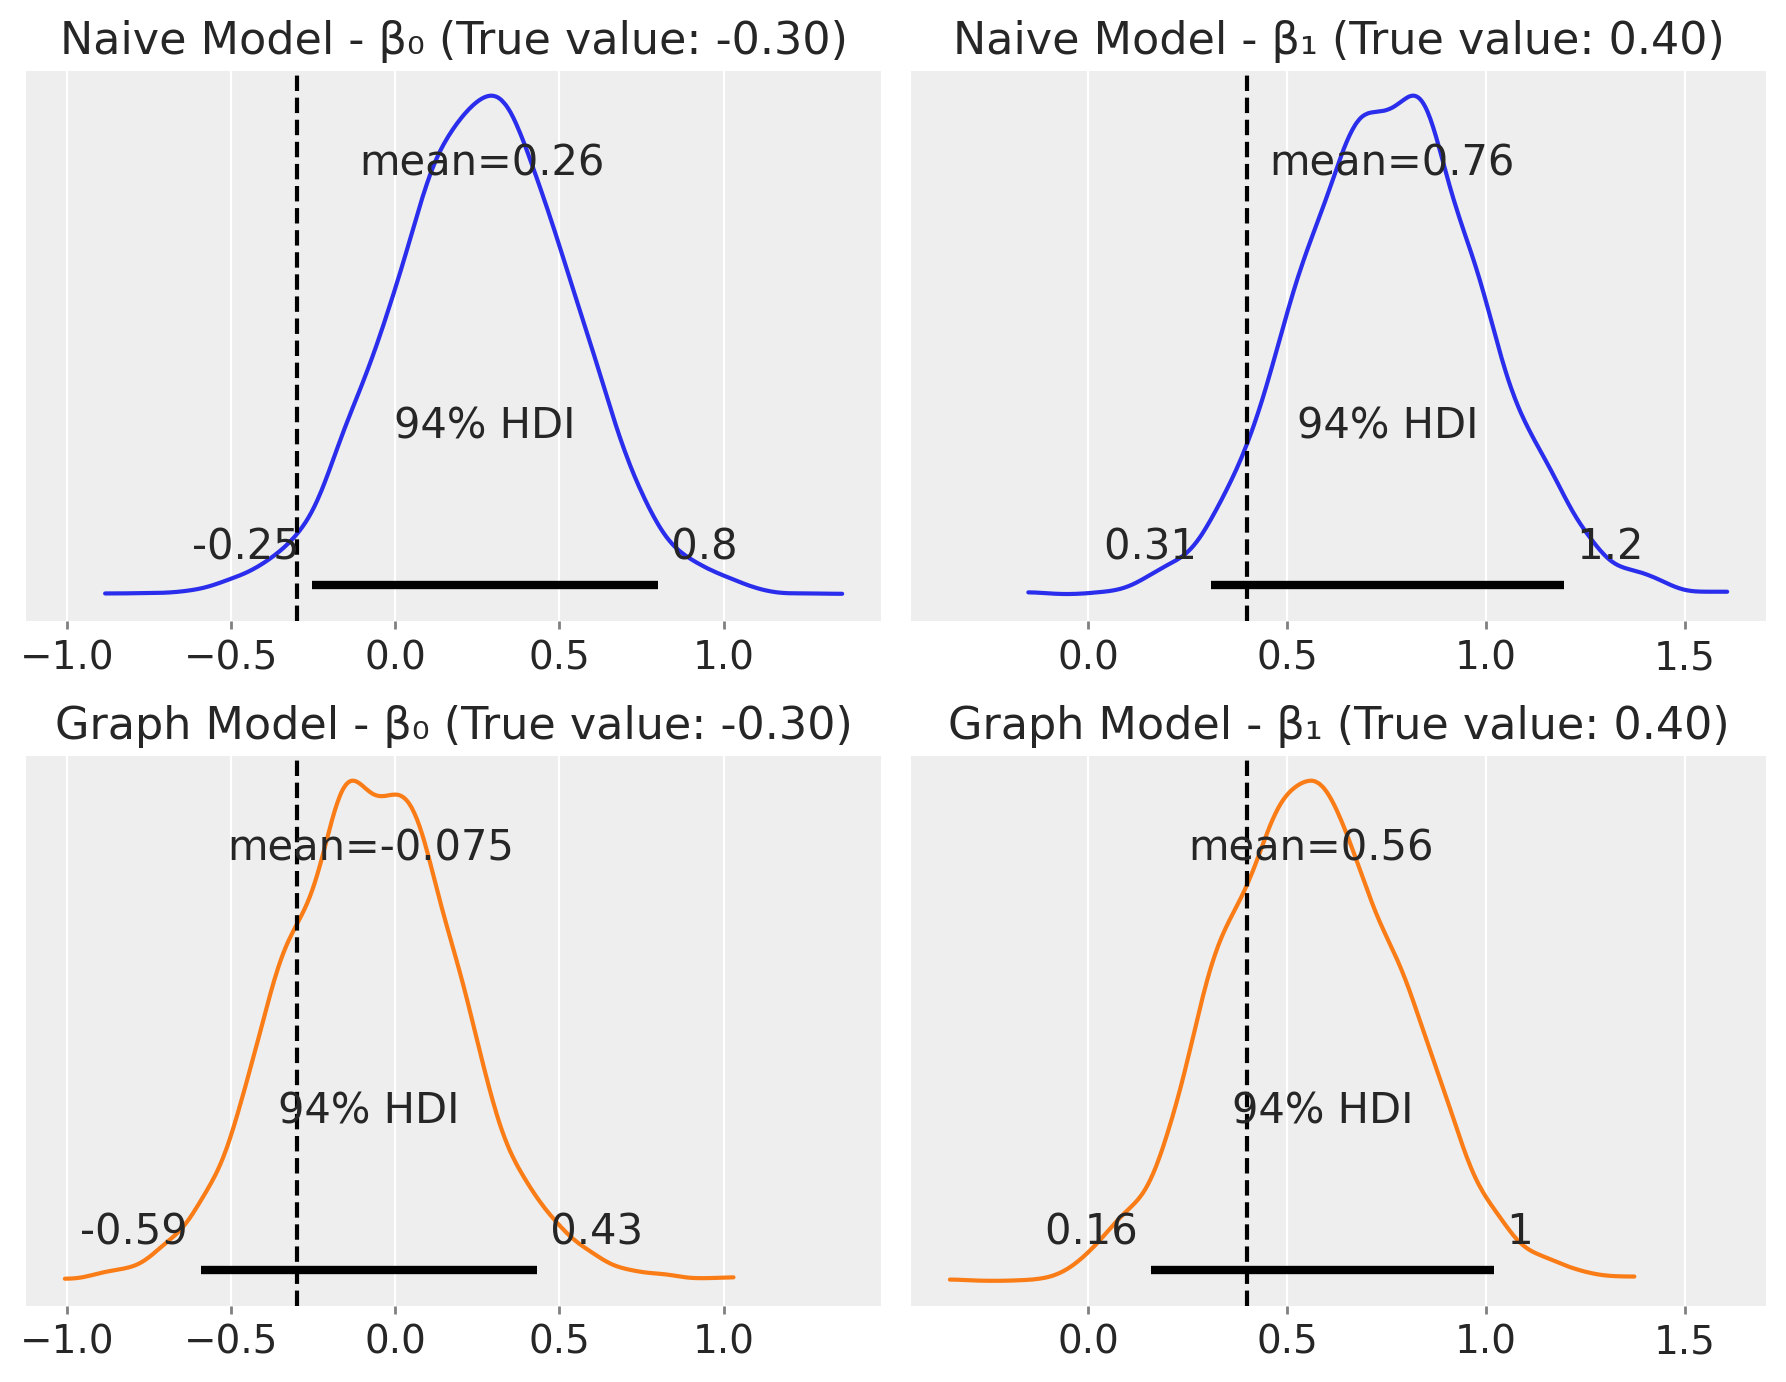

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(9, 7), sharex="col")

az.plot_posterior(trace_naive, var_names=["beta"], coords={"beta_dim_0": 0}, ax=axs[0, 0], color="C0")
axs[0, 0].axvline(beta_true[0], color="k", linestyle="--")
axs[0, 0].set_title(f"Naive Model - β₀ (True value: {beta_true[0]:.2f})")

az.plot_posterior(trace_naive, var_names=["beta"], coords={"beta_dim_0": 1}, ax=axs[0, 1], color="C0")
axs[0, 1].axvline(beta_true[1], color="k", linestyle="--")
axs[0, 1].set_title(f"Naive Model - β₁ (True value: {beta_true[1]:.2f})")

az.plot_posterior(trace_graph, var_names=["beta"], coords={"beta_dim_0": 0}, ax=axs[1, 0], color="C1")
axs[1, 0].axvline(beta_true[0], color="k", linestyle="--")
axs[1, 0].set_title(f"Graph Model - β₀ (True value: {beta_true[0]:.2f})")

az.plot_posterior(trace_graph, var_names=["beta"], coords={"beta_dim_0": 1}, ax=axs[1, 1], color="C1")
axs[1, 1].axvline(beta_true[1], color="k", linestyle="--", label="True value of β₁")
axs[1, 1].set_title(f"Graph Model - β₁ (True value: {beta_true[1]:.2f})")

plt.tight_layout()


Using the `MvNormal` likelihood took longer, but the advantages are clear: after accounting for the correlated errors, our coefficient estimates are much better in terms of HDI width as well as distance between the posterior mean and the true value used to produce the dataset.

Unfortunately, using the `MvNormal` likelihood in this example incurs a $\mathcal(N^3)$ computation cost from applying the Cholesky decomposition to $\Sigma$ in order to compute $ \log p(\mathbf{y} \mid \mathbf{\mu}, \Sigma )$.

Having set the basic context for modeling, let's discuss some concrete computational considerations for conducting inference more efficiently:
- First, by assuming which elements of $\mathbf{\epsilon}$ depend on each other in a DAG-structured manner, we can model the covariance of $\mathbf{\epsilon}$ in terms of a lower-triangular factorized form of $\Lambda$ and thus $\Sigma$.
- The two main sources of computational cost for modeling with a multivariate normal likelihood are (1) the determinant of the covariance matrix, $\det(\Sigma)$, and (2) the calculation of the inner product $\mathbf{\epsilon}^T \Lambda \mathbf{\epsilon}$

We will use the structural assumptions of our model to make these operations cheaper. Beginning with (1), our assumptions for $\Lambda$ let us write the following by using some basic matrix identities:

$$
\begin{align*}
\det(\Sigma) &= \det(\Lambda)^{-1}\\
&= \det((I-G)^T\Omega(I-G))\\
&= \det(\Omega) (\det(I-G))^2\\
&= \det(\Omega) \\
&= \prod_i \omega_{ii}
\end{align*}
$$

This gives us an $\mathcal{O}(N)$ formula for $\det(\Sigma)$ which normally requires $\mathcal{O}(N^3)$ computation with relaxed assumptions. We are fortunate here that $\det(I-G) = 1$ as the determinant of a triangular matrix is given by the product of its diagonals; since $G$ has no diagonal elements and $I$ is the identity matrix, this product is equal to 1.

For item (2) from above, we can rewrite $\mathbf{\epsilon}^T \Lambda \mathbf{\epsilon}$ as $\mathbf{u} = \mathbf{\epsilon}^T (I - G)^T \Omega^{1/2}$ such that $\mathbf{\epsilon}^T \Lambda \mathbf{\epsilon} = \mathbf{u}^T\mathbf{u}$. Since $\Omega$ is diagonal, $\Omega^{1/2}$ is just the elementwise square root of $\Omega$. Then, since $B$ is sparse, the dot product $\mathbf{\epsilon}^T(I-G)$ will also be relatively cheap.

To use these alterations, we'll make a new `sparse_prec_mvn_logp` function that leverages the sparsity of $B$ for more efficient `logp` calculations. We'll add this to the model using `pm.Potential`,

In [ ]:

def sparse_prec_mvn_logp(value, mu, omega_diag, G):
    '''
    Log probability for MVN specified in terms of precision matrix Lambda = (I - G) diag(omega_diag) (I - G)^T
    where G is a sparse matrix (DAG structure) and omega_diag is a vector of diagonal elements of the precision matrix.
    This is a custom implementation of the log probability function for a multivariate normal distribution
    with a sparse precision matrix.

    value: n-dimensional vector of observations
    mu: n-dimensional vector of means
    omega_diag: n-dimensional vector of diagonal elements of the precision matrix
    B: n x n sparse matrix (DAG structure)
    '''
    value = pt.as_tensor_variable(value)

    delta = value - mu
    I = sparse.square_diagonal(pt.ones(B.shape[0]))
    print(I.shape.eval(), G.shape.eval())
    print(type(I), type(G))

    # Commenting out the - G part lets it sample
    # TODO: unravel why this is a problem
    IminusG = sparse.sub(I,G)

    omega = sparse.square_diagonal(omega_diag)
    prec = sparse.basic.mul(
            sparse.basic.mul(
                IminusG.T, omega
            ),
            IminusG
        )
    
    # Should work with sparse prec, dense delta -> dense vector
    prec_delta = sparse.dot(prec, delta[:, None])
    dLd = pt.dot(delta[None, :], prec_delta)
    quaddist = pt.sum(dLd)

    logdet = pt.sum(pt.log(omega_diag))
    k = value.shape[-1].astype("floatX")
    norm = -0.5 * k * 1.8378770664093453  # log(2 * pi)

    return norm - 0.5 * quaddist + 0.5 * logdet

with pm.Model() as sparse_graph_model:
    beta = pm.Normal("beta", 0, 5, shape=p)

    prec_diagonal = pm.HalfNormal("prec_diagonal", 1)
    prec_offdiagonal = pm.HalfNormal("prec_offdiagonal", 1)

    dag_pt = sparse.as_sparse_or_tensor_variable(dag.astype(float))
    G = prec_offdiagonal * dag_pt
    mu = pt.dot(x, beta)
    omega_diag = pt.ones(n) * prec_diagonal

    _ = pm.Potential("likelihood", 
        sparse_prec_mvn_logp(y, mu, omega_diag, G)
    )

    ω = pm.HalfNormal('ω', shape=n)
    β = pm.Normal("β", shape=p)
    μ = pm.Normal('x', shape=n)
    γ = pm.HalfNormal("γ")
    μ = X @ β
    δ = pm.math.constant(y) - μ
    I = sparse.square_diagonal(pt.ones(n))
    G_pt = sparse.as_sparse_or_tensor_variable(G) * γ

    IminusG = sparse.sub(I, G_pt)

    Ω = sparse.square_diagonal(ω)
    Λ = sparse.basic.mul(sparse.basic.mul(G_pt, Ω,), G_pt)

    Λδ = sparse.dot(Λ, δ[:, None])

    quaddist = pt.dot(δ[None, :],Λδ)
    logdet = pt.sum(pt.log(ω))

    likelihood = -0.5 * pm.math.constant(n) * np.log(2 * np.pi)  # log(2 * pi)

    pm.Potential('likelihood', likelihood)

with sparse_graph_model:
    trace_sparse_graph = pm.sample()

# with graph_model:
#     trace_graph = pm.sample()


[20 20] [20 20]
<class 'pytensor.sparse.basic.SparseVariable'> <class 'pytensor.sparse.basic.SparseVariable'>


TypeError: 

In [31]:
dag_pt

SparseConstant{csr,float64,shape=(20, 20),nnz=52}

In [ ]:
sparse_graph_model.v

The next code cell generates the data via creating latent variable arrays `M` and linear transformation `Q`. Then, the matrix product $QM$ is perturbed with additive Gaussian noise controlled by the variance parameter `err_sd`.

In [ ]:
err_sd = 2
M = rng.binomial(1, 0.25, size=(k_true, n))
Q = np.hstack([rng.exponential(2 * k_true - k, size=(d, 1)) for k in range(k_true)]) * rng.binomial(
    1, 0.75, size=(d, k_true)
)
Y = np.round(1000 * Q @ M + rng.standard_normal(size=(d, n)) * err_sd) / 1000

Because of the way we have generated the data, the covariance matrix expressing correlations between columns of $Y$ will be equal to $QQ^T$. The fundamental assumption of PCA and factor analysis is that $QQ^T$ is not full rank. We can see hints of this if we plot the covariance matrix:

In [ ]:
plt.figure(figsize=(4, 3))
sns.heatmap(np.corrcoef(Y));

If you squint long enough, you may be able to glimpse a few places where distinct columns are likely linear functions of each other.

## Model
Probabilistic PCA (PPCA) and factor analysis (FA) are a common source of topics on [PyMC Discourse](https://discourse.pymc.io/). The posts linked below handle different aspects of the problem including:
* [Minibatched FA for large datasets](https://discourse.pymc.io/t/large-scale-factor-analysis-with-minibatch-advi/246)
* [Handling missing data in FA](https://discourse.pymc.io/t/dealing-with-missing-data/252)
* [Identifiability in FA / PPCA](https://discourse.pymc.io/t/unique-solution-for-probabilistic-pca/1324/14)

### Direct implementation

The model for factor analysis is the probabilistic matrix factorization

$X_{(d,n)}|W_{(d,k)}, F_{(k,n)} \sim \mathcal{N}(WF, \Psi)$

with $\Psi$ a diagonal matrix. Subscripts denote the dimensionality of the matrices. Probabilistic PCA is a variant that sets $\Psi = \sigma^2 I$. A basic implementation (taken from [this gist](https://gist.github.com/twiecki/c95578a6539d2098be2d83575e3d15fe)) is shown in the next cell. Unfortunately, it has undesirable properties for model fitting.

In [ ]:
k = 2

coords = {"latent_columns": np.arange(k), "rows": np.arange(n), "observed_columns": np.arange(d)}

with pm.Model(coords=coords) as PPCA:
    W = pm.Normal("W", dims=("observed_columns", "latent_columns"))
    F = pm.Normal("F", dims=("latent_columns", "rows"))
    sigma = pm.HalfNormal("sigma", 1.0)
    X = pm.Normal("X", mu=W @ F, sigma=sigma, observed=Y, dims=("observed_columns", "rows"))

    trace = pm.sample(tune=2000, random_seed=rng)  # target_accept=0.9

At this point, there are already several warnings regarding failed convergence checks. We can see further problems in the trace plot below. This plot shows the path taken by each sampler chain for a single entry in the matrix $W$ as well as the average evaluated over samples for each chain.

In [ ]:
for i in trace.posterior.chain.values:
    samples = trace.posterior["W"].sel(chain=i, observed_columns=3, latent_columns=1)
    plt.plot(samples, label="Chain {}".format(i + 1))
    plt.axhline(samples.mean(), color=f"C{i}")
plt.legend(ncol=4, loc="upper center", fontsize=12, frameon=True), plt.xlabel("Sample");

Each chain appears to have a different sample mean and we can also see that there is a great deal of autocorrelation across chains, manifest as long-range trends over sampling iterations.

One of the primary drawbacks for this model formulation is its lack of identifiability. With this model representation, only the product $WF$ matters for the likelihood of $X$, so $P(X|W, F) = P(X|W\Omega, \Omega^{-1}F)$ for any invertible matrix $\Omega$. While the priors on $W$ and $F$ constrain $|\Omega|$ to be neither too large or too small, factors and loadings can still be rotated, reflected, and/or permuted *without changing the model likelihood*. Expect it to happen between runs of the sampler, or even for the parametrization to "drift" within run, and to produce the highly autocorrelated $W$ traceplot above.

### Alternative parametrization

This can be fixed by constraining the form of W to be:
  + Lower triangular
  + Positive and increasing values along the diagonal

We can adapt `expand_block_triangular` to fill out a non-square matrix. This function mimics `pm.expand_packed_triangular`, but while the latter only works on packed versions of square matrices (i.e. $d=k$ in our model, the former can also be used with nonsquare matrices.

In [ ]:
def expand_packed_block_triangular(d, k, packed, diag=None, mtype="pytensor"):
    # like expand_packed_triangular, but with d > k.
    assert mtype in {"pytensor", "numpy"}
    assert d >= k

    def set_(M, i_, v_):
        if mtype == "pytensor":
            return pt.set_subtensor(M[i_], v_)
        M[i_] = v_
        return M

    out = pt.zeros((d, k), dtype=float) if mtype == "pytensor" else np.zeros((d, k), dtype=float)
    if diag is None:
        idxs = np.tril_indices(d, m=k)
        out = set_(out, idxs, packed)
    else:
        idxs = np.tril_indices(d, k=-1, m=k)
        out = set_(out, idxs, packed)
        idxs = (np.arange(k), np.arange(k))
        out = set_(out, idxs, diag)
    return out

We'll also define another function which helps create a diagonal matrix with increasing entries along the main diagonal.

In [ ]:
def makeW(d, k, dim_names):
    # make a W matrix adapted to the data shape
    n_od = int(k * d - k * (k - 1) / 2 - k)

    # trick: the cumulative sum of z will be positive increasing
    z = pm.HalfNormal("W_z", 1.0, dims="latent_columns")
    b = pm.Normal("W_b", 0.0, 1.0, shape=(n_od,), dims="packed_dim")
    L = expand_packed_block_triangular(d, k, b, pt.ones(k))
    W = pm.Deterministic("W", L @ pt.diag(pt.extra_ops.cumsum(z)), dims=dim_names)
    return W

With these modifications, we remake the model and run the MCMC sampler again.

In [ ]:
with pm.Model(coords=coords) as PPCA_identified:
    W = makeW(d, k, ("observed_columns", "latent_columns"))
    F = pm.Normal("F", dims=("latent_columns", "rows"))
    sigma = pm.HalfNormal("sigma", 1.0)
    X = pm.Normal("X", mu=W @ F, sigma=sigma, observed=Y, dims=("observed_columns", "rows"))
    trace = pm.sample(tune=2000, random_seed=rng)  # target_accept=0.9

for i in range(4):
    samples = trace.posterior["W"].sel(chain=i, observed_columns=3, latent_columns=1)
    plt.plot(samples, label="Chain {}".format(i + 1))

plt.legend(ncol=4, loc="lower center", fontsize=8), plt.xlabel("Sample");

$W$ (and $F$!) now have entries with identical posterior distributions as compared between sampler chains, although it's apparent that some autocorrelation remains.

Because the $k \times n$ parameters in F all need to be sampled, sampling can become quite expensive for very large `n`. In addition, the link between an observed data point $X_i$ and an associated latent value $F_i$ means that streaming inference with mini-batching cannot be performed.

This scalability problem can be addressed analytically by integrating $F$ out of the model. By doing so, we postpone any calculation for individual values of $F_i$ until later. Hence, this approach is often described as *amortized inference*. However, this fixes the prior on $F$, allowing for less modeling flexibility. In keeping with $F_{ij} \sim \mathcal{N}(0, I)$ we have:

$X|WF \sim \mathcal{N}(WF, \sigma^2 I).$

We can therefore write $X$ as

$X = WF + \sigma I \epsilon,$

where $\epsilon \sim \mathcal{N}(0, I)$.
Fixing $W$ but treating $F$ and $\epsilon$ as random variables, both $\sim\mathcal{N}(0, I)$, we see that $X$ is the sum of two multivariate normal variables, with means $0$ and covariances $WW^T$ and $\sigma^2 I$, respectively. It follows that

$X|W \sim \mathcal{N}(0, WW^T + \sigma^2 I )$.

In [ ]:
with pm.Model(coords=coords) as PPCA_amortized:
    W = makeW(d, k, ("observed_columns", "latent_columns"))
    sigma = pm.HalfNormal("sigma", 1.0)
    cov = W @ W.T + sigma**2 * pt.eye(d)
    # MvNormal parametrizes covariance of columns, so transpose Y
    X = pm.MvNormal("X", 0.0, cov=cov, observed=Y.T, dims=("rows", "observed_columns"))
    trace_amortized = pm.sample(tune=30, draws=100, random_seed=rng)

Unfortunately sampling of this model is very slow, presumably because calculating the logprob of the `MvNormal` requires inverting the covariance matrix. However, the explicit integration of $F$ also enables batching the observations for faster computation of `ADVI` and `FullRankADVI` approximations.

In [ ]:
coords["observed_columns2"] = coords["observed_columns"]
with pm.Model(coords=coords) as PPCA_amortized_batched:
    W = makeW(d, k, ("observed_columns", "latent_columns"))
    Y_mb = pm.Minibatch(
        Y.T, batch_size=50
    )  # MvNormal parametrizes covariance of columns, so transpose Y
    sigma = pm.HalfNormal("sigma", 1.0)
    cov = W @ W.T + sigma**2 * pt.eye(d)
    X = pm.MvNormal("X", 0.0, cov=cov, observed=Y_mb)
    trace_vi = pm.fit(n=50000, method="fullrank_advi", obj_n_mc=1).sample()

## Results
When we compare the posteriors calculated using MCMC and VI, we find that (for at least this specific parameter we are looking at) the two distributions are close, but they do differ in their mean. The two MCMC posteriors agree with each other quite well with each other and the ADVI estimate is not far off.

In [ ]:
col_selection = dict(observed_columns=3, latent_columns=1)

ax = az.plot_kde(
    trace.posterior["W"].sel(**col_selection).values,
    label="MCMC posterior for the explicit model".format(0),
    plot_kwargs={"color": f"C{1}"},
)

az.plot_kde(
    trace_amortized.posterior["W"].sel(**col_selection).values,
    label="MCMC posterior for amortized inference",
    plot_kwargs={"color": f"C{2}", "linestyle": "--"},
)


az.plot_kde(
    trace_vi.posterior["W"].sel(**col_selection).squeeze().values,
    label="FR-ADVI posterior for amortized inference",
    plot_kwargs={"alpha": 0},
    fill_kwargs={"alpha": 0.5, "color": f"C{0}"},
)


ax.set_title(rf"PDFs of $W$ estimate at {col_selection}")
ax.legend(loc="upper left", fontsize=10);

### Post-hoc identification of F

The matrix $F$ is typically of interest for factor analysis, and is often used as a feature matrix for dimensionality reduction. However, $F$ has been
marginalized away in order to make fitting the model easier; and now we need it back. Transforming

$X|WF \sim \mathcal{N}(WF, \sigma^2)$

into

$(W^TW)^{-1}W^T X|W,F \sim \mathcal{N}(F, \sigma^2(W^TW)^{-1})$

we have represented $F$ as the mean of a multivariate normal distribution with a known covariance matrix. Using the prior $ F \sim \mathcal{N}(0, I) $ and updating according to the expression for the [conjugate prior](https://en.wikipedia.org/wiki/Conjugate_prior), we find

$ F | X, W \sim \mathcal{N}(\mu_F, \Sigma_F) $,

where

$\mu_F = \left(I + \sigma^{-2} W^T W\right)^{-1} \sigma^{-2} W^T X$

$\Sigma_F = \left(I + \sigma^{-2} W^T W\right)^{-1}$

For each value of $W$ and $X$ found in the trace, we now draw a sample from this distribution.

In [ ]:
# configure xarray-einstats
def get_default_dims(dims, dims2):
    proposed_dims = [dim for dim in dims if dim not in {"chain", "draw"}]
    assert len(proposed_dims) == 2
    if dims2 is None:
        return proposed_dims


linalg.get_default_dims = get_default_dims

In [ ]:
post = trace_vi.posterior
obs = trace.observed_data

WW = linalg.matmul(
    post["W"], post["W"], dims=("latent_columns", "observed_columns", "latent_columns")
)

# Constructing an identity matrix following https://einstats.python.arviz.org/en/latest/tutorials/np_linalg_tutorial_port.html
I = xr.zeros_like(WW)
idx = xr.DataArray(WW.coords["latent_columns"])
I.loc[{"latent_columns": idx, "latent_columns2": idx}] = 1
Sigma_F = linalg.inv(I + post["sigma"] ** (-2) * WW)
X_transform = linalg.matmul(
    Sigma_F,
    post["sigma"] ** (-2) * post["W"],
    dims=("latent_columns2", "latent_columns", "observed_columns"),
)
mu_F = xr.dot(X_transform, obs["X"], dims="observed_columns").rename(
    latent_columns2="latent_columns"
)
Sigma_chol = linalg.cholesky(Sigma_F)
norm_dist = XrContinuousRV(sp.stats.norm, xr.zeros_like(mu_F))  # the zeros_like defines the shape
F_sampled = mu_F + linalg.matmul(
    post["sigma"] * Sigma_F,
    norm_dist.rvs(),
    dims=(("latent_columns", "latent_columns2"), ("latent_columns", "rows")),
)

### Comparison to original data

To check how well our model has captured the original data, we will test how well we can reconstruct it from the sampled $W$ and $F$ matrices. For each element of $Y$ we plot the mean and standard deviation of $X = W F$, which is the reconstructed value based on our model.

In [ ]:
X_sampled_amortized = linalg.matmul(
    post["W"],
    F_sampled,
    dims=("observed_columns", "latent_columns", "rows"),
)
reconstruction_mean = X_sampled_amortized.mean(dim=("chain", "draw")).values
reconstruction_sd = X_sampled_amortized.std(dim=("chain", "draw")).values
plt.errorbar(
    Y.ravel(),
    reconstruction_mean.ravel(),
    yerr=reconstruction_sd.ravel(),
    marker=".",
    ls="none",
    alpha=0.3,
)

slope, intercept, r_value, p_value, std_err = sp.stats.linregress(
    Y.ravel(), reconstruction_mean.ravel()
)
plt.plot(
    [Y.min(), Y.max()],
    np.array([Y.min(), Y.max()]) * slope + intercept,
    "k--",
    label=f"Linear regression for the mean, R²={r_value**2:.2f}",
)
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], "k:", label="Perfect reconstruction")

plt.xlabel("Elements of Y")
plt.ylabel("Model reconstruction")
plt.legend(loc="upper left");

We find that our model does a decent job of capturing the variation in the original data, despite only using two latent factors instead of the actual four.

## Authors
* Authored by [chartl](https://github.com/chartl) on May 6, 2019
* Updated by [Christopher Krapu](https://github.com/ckrapu) on April 4, 2021
* Updated by Oriol Abril-Pla to use PyMC v4 and xarray-einstats on March, 2022
* Updated by Erik Werner on Dec, 2023 ([pymc-examples#612](https://github.com/pymc-devs/pymc-examples/pull/612))

## Watermark

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w

:::{include} ../page_footer.md
:::